In [139]:
import numpy as np
import random as rand
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from geopandas.tools import sjoin
import seaborn as sns
from shapely.geometry import Point
from shapely.ops import polygonize
from shapely.geometry import MultiLineString
from shapely.geometry import Polygon, Point
from shapely import affinity
import contextily as ctx
import libpysal as ps
import pointpats.quadrat_statistics as qs
from pointpats import PointPattern, as_window
from pointpats import PoissonPointProcess as csr
from rtree import index
from collections import Counter
from pprint import pprint
import skgstat as skg
from collections import Counter
from sklearn.cluster import DBSCAN
from pointpats import (
    distance_statistics,
    QStatistic,
    random,
    PointPattern,
)
from pyproj import Proj
import pyproj

import numpy as np
from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings("ignore") 

In [89]:
plt.style.use('ggplot')
sns.set_style("whitegrid")

Huanan Seafood market data sourced from: 

"Data and code for: The Huanan Seafood Wholesale Market in Wuhan was the early epicenter of the COVID-19" https://zenodo.org/record/6908012

WHO 2021. WHO-convened Global Study of Origins of SARS-CoV-2 : China Part (14 January-10 February 2021). https://www.who.int/docs/default-source/coronaviruse/final-joint-report_origins-studies-6-april-201.pdf

Gao G, Liu W, Wong G, Wang J, Wang F, Li M. Surveillance of SARS-CoV-2 in the environment and animal samples of the Huanan Seafood Market. Res Sq. doi:10.21203/rs.3.rs-1370392/v1

In [90]:
wgs84=pyproj.Proj("+init=EPSG:4326")
utm=pyproj.Proj("+proj=utm +zone=50 +north +ellps=WGS84 +datum=WGS84 +units=m +no_defs")

In [91]:
DATA_PATH='/mnt/1TB_0/Data/GIS/Wuhan_Early_Cases/'

In [140]:
df_original = gpd.read_file(DATA_PATH+"geojson/huanan-market-internal_edit.geojson")

In [141]:
df_original.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [92]:
df_who = gpd.read_file(DATA_PATH+"geojson/UTM_Zone50N/huanan-market-internal_data_UTM_Z50N.geojson")
#df_who = gpd.read_file(DATA_PATH+"geojson/huanan-market-internal_edit.geojson")

In [93]:
df_who.head()

,title,group,fill,label,marker-color,stroke,geometry
0,B17 (scale),Env-Pos,None,None,#cc1b15,None,POINT (236976.239 3390713.615)
1,D32 (wagon surface),Env-Pos,None,None,#cc1b15,None,POINT (237022.316 3390718.370)
2,F13 (wall surface),Env-Pos,None,None,#cc1b15,None,POINT (237020.571 3390690.122)
3,"E48 (blood from ground surface, in front of door)",Env-Pos,None,None,#cc1b15,None,POINT (237126.234 3390706.626)
4,E61 (ground surface),Env-Pos,None,None,#cc1b15,None,POINT (237107.840 3390668.466)


In [94]:
df_who.group.unique()

array(['Env-Pos', 'StreetNumber', 'WildlifeVendor', 'UnknownMeat',
       'Env-Neg', 'HumanCase'], dtype=object)

In [95]:
def create_xy(df):
    x=df['geometry'].apply(lambda p: p.x)
    y=df['geometry'].apply(lambda p: p.y)

    df['x']=x
    df['y']=y
    return df

In [96]:
df_who=create_xy(df_who)

In [97]:
df_map = gpd.read_file(DATA_PATH+"geojson/UTM_Zone50N/HSM_internal_UTM_Z50N.geojson")

In [98]:
df_map.head()

,title,group,fill,label,marker-color,stroke,geometry
0,,MarketMap,None,None,None,None,"LINESTRING (237143.809 3390675.798, 237105.482..."
1,,MarketMap,None,None,None,None,"LINESTRING (237144.599 3390672.783, 237106.272..."
2,,MarketMap,None,None,None,None,"LINESTRING (237141.713 3390684.281, 237103.386..."
3,,MarketMap,None,None,None,None,"LINESTRING (237142.503 3390681.266, 237104.080..."
4,,MarketMap,None,None,None,None,"LINESTRING (237139.626 3390693.097, 237101.104..."


In [99]:
### Cases

In [100]:
cases_df=df_who[df_who["group"].isin(['HumanCase'])].copy(deep=True)
cases_df['id'] = cases_df.index

In [155]:
cases_df.head()

,title,group,fill,label,marker-color,stroke,geometry,x,y,id
187,After,HumanCase,None,None,#fb6033,None,POINT (237000.588 3390685.173),237000.588419,3.390685e+06,187
188,After,HumanCase,None,None,#fb6033,None,POINT (237013.108 3390628.063),237013.107736,3.390628e+06,188
189,After,HumanCase,None,None,#fb6033,None,POINT (237006.392 3390655.631),237006.392167,3.390656e+06,189
190,After,HumanCase,None,None,#fb6033,None,POINT (236976.239 3390713.615),236976.238960,3.390714e+06,190
191,After,HumanCase,None,None,#fb6033,None,POINT (236997.851 3390730.284),236997.851401,3.390730e+06,191


In [149]:
len(cases_df)

31

In [146]:
cases_west_df =  cases_df.loc[cases_df['x'] < 237100]

In [150]:
len(cases_west_df)
cases_west_df.drop(['x', 'y'], axis=1, inplace=True)


In [153]:
cases_west_df.to_file('/mnt/1TB_0/Data/GIS/Wuhan_Early_Cases/geojson/UTM_Zone50N/HSM_cases_West_UTM_Z50N.geojson', driver="GeoJSON")  

In [ ]:
# cases to 20th Dec

In [ ]:
df_who = gpd.read_file(DATA_PATH+"geojson/UTM_Zone50N/huanan-market-internal_data_UTM_Z50N.geojson")

### buffer plots

create jitter 10-50cm

In [102]:
s=5
jitter=[]
for i in range(-s, s+1):
    jitter.append(i/10)
    
def add_jitter(x):
    return x+rand.choice(jitter)

In [103]:
def apply_jitter(df):
    df['jx'] = df['x'].apply(add_jitter)
    df['jy'] = df['y'].apply(add_jitter)
    geometry = gpd.points_from_xy(df['jx'], df['jy'],  crs=df_map.crs)

    df['jit_geometry']=geometry

    df=df.drop(['geometry'], axis=1)
    df.rename(columns = {'jit_geometry':'geometry'}, inplace = True)
    return df

In [104]:
cases_jit_df=cases_df.copy(deep=True)
cases_jit_df=apply_jitter(cases_jit_df)

In [105]:
cases_jit_df.head()

,title,group,fill,label,marker-color,stroke,x,y,id,jx,jy,geometry
187,After,HumanCase,None,None,#fb6033,None,237000.588419,3.390685e+06,187,237000.588419,3.390685e+06,POINT (237000.588 3390684.673)
188,After,HumanCase,None,None,#fb6033,None,237013.107736,3.390628e+06,188,237012.607736,3.390628e+06,POINT (237012.608 3390628.363)
189,After,HumanCase,None,None,#fb6033,None,237006.392167,3.390656e+06,189,237006.592167,3.390656e+06,POINT (237006.592 3390655.731)
190,After,HumanCase,None,None,#fb6033,None,236976.238960,3.390714e+06,190,236976.038960,3.390713e+06,POINT (236976.039 3390713.115)
191,After,HumanCase,None,None,#fb6033,None,236997.851401,3.390730e+06,191,236997.451401,3.390731e+06,POINT (236997.451 3390730.784)


In [106]:
df_gao_wildlife = gpd.read_file(DATA_PATH+"geojson/UTM_Zone50N/Gao_wildlife_UTM_Z50N.geojson")
df_toilets = gpd.read_file(DATA_PATH+"geojson/UTM_Zone50N/Toilets_UTM_Z50N.geojson")

<AxesSubplot:>

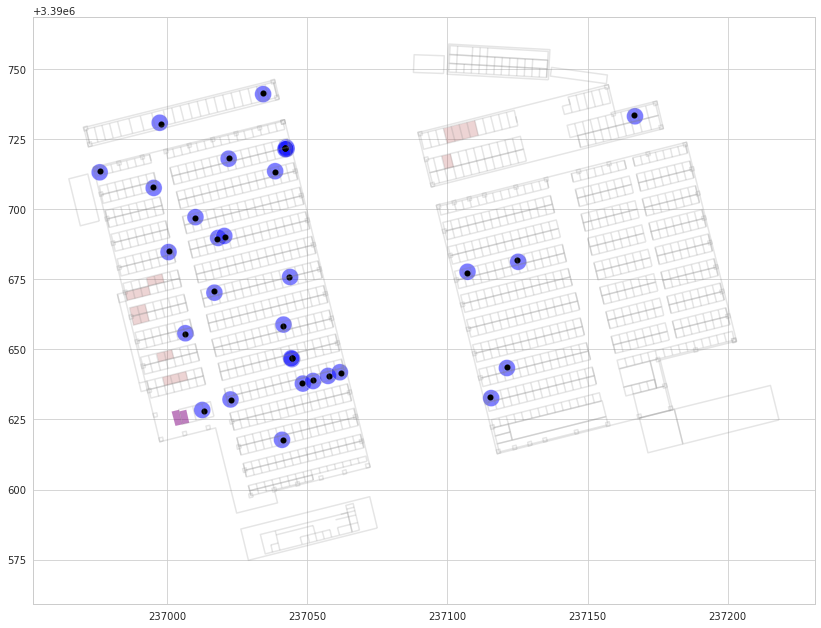

In [107]:
fig, ax = plt.subplots(figsize = (14,14))
df_map.plot(ax=ax, color="grey", alpha = .2 )
cases_jit_df["buffered"] = cases_jit_df.buffer(3)
cases_jit_df["buffered"].plot(ax=ax, color="blue", alpha=.5)
cases_df.plot(ax=ax, color="black", linewidth=.1)
df_gao_wildlife.plot(ax=ax, color="brown", linewidth=.1, alpha=.2)
df_toilets.plot(ax=ax, color="purple", linewidth=.1, alpha=.5)

In [108]:
df_cases_1_13 = gpd.read_file(DATA_PATH+"geojson/UTM_Zone50N/WHO_HSM_vendor_cases_1_2019-12-13_UTM_Z50N.geojson")
df_cases_1_20 = gpd.read_file(DATA_PATH+"geojson/UTM_Zone50N/WHO_HSM_vendor_cases_1_2019-12-20_UTM_Z50.geojson")
df_cases_2_20 = gpd.read_file(DATA_PATH+"geojson/UTM_Zone50N/WHO_HSM_vendor_cases_2_2019-12-20_UTM_Z50.geojson")
df_cases_2_20a=df_cases_2_20.copy()
df_cases_20 = gpd.GeoDataFrame( pd.concat( [df_cases_1_13, df_cases_1_20,df_cases_2_20, df_cases_2_20a], ignore_index=True) )
df_cases_20_new = gpd.GeoDataFrame( pd.concat( [df_cases_1_20,df_cases_2_20, df_cases_2_20a], ignore_index=True) )

df_cases_1_27 = gpd.read_file(DATA_PATH+"geojson/UTM_Zone50N/WHO_HSM_vendor_cases_1_2019-12-27_UTM_Z50N.geojson")
#one copy as adding second
df_cases_2_27 = gpd.read_file(DATA_PATH+"geojson/UTM_Zone50N/WHO_HSM_vendor_cases_2_2019-12-27_UTM_Z50N.geojson")
#one copy as adding 3rd
df_cases_3_27_3 = gpd.read_file(DATA_PATH+"geojson/UTM_Zone50N/WHO_HSM_vendor_cases_3_2019-12-27_UTM_Z50N.geojson")
df_cases_27 = gpd.GeoDataFrame( pd.concat( [df_cases_20,df_cases_1_27,df_cases_2_27, df_cases_3_27_3], ignore_index=True) )
df_cases_27_new = gpd.GeoDataFrame( pd.concat( [df_cases_1_27,df_cases_2_27, df_cases_3_27_3], ignore_index=True) )

df_cases_1_31 = gpd.read_file(DATA_PATH+"geojson/UTM_Zone50N/WHO_HSM_vendor_cases_1_2019-12-31_UTM_Z50N.geojson")
df_cases_31 = gpd.GeoDataFrame( pd.concat( [df_cases_27, df_cases_1_31], ignore_index=True) )
df_cases_31_new = gpd.GeoDataFrame( pd.concat( [df_cases_1_31], ignore_index=True) )

df_cases_1_13=create_xy(df_cases_1_13)
df_cases_1_13=apply_jitter(df_cases_1_13)
df_cases_20=create_xy(df_cases_20)
df_cases_20=apply_jitter(df_cases_20)
df_cases_20_new=create_xy(df_cases_20_new)
df_cases_20_new=apply_jitter(df_cases_20_new)
df_cases_27=create_xy(df_cases_27)
df_cases_27=apply_jitter(df_cases_27)
df_cases_27_new=create_xy(df_cases_27_new)
df_cases_27_new=apply_jitter(df_cases_27_new)
df_cases_31=create_xy(df_cases_31)
df_cases_31=apply_jitter(df_cases_31)
df_cases_31_new=create_xy(df_cases_31_new)
df_cases_31_new=apply_jitter(df_cases_31_new)


In [109]:
sns.set_style('white')

In [110]:
def time_case_plot(df_l, colour_l, alpha_l, alpha_pt_l, buffer, file_name=None):
    fig, ax = plt.subplots(figsize = (14,14))
    df_map.plot(ax=ax, color="grey", alpha = .2 )
    df_gao_wildlife.plot(ax=ax, color="brown", linewidth=.1, alpha=.2)
    df_toilets.plot(ax=ax, color="purple", linewidth=.1, alpha=.5)
    for df, colour, alpha, alpha_pt in zip(df_l, colour_l, alpha_l, alpha_pt_l):
        df["buffered"] = df.buffer(buffer)
        df["buffered"].plot(ax=ax, color=colour, alpha=alpha)
        df.plot(ax=ax, color="black", linewidth=.1, alpha=alpha_pt)
    plt.tight_layout()
    if file_name:
        plt.savefig(DATA_PATH+f"Images/{file_name}") 
    
        

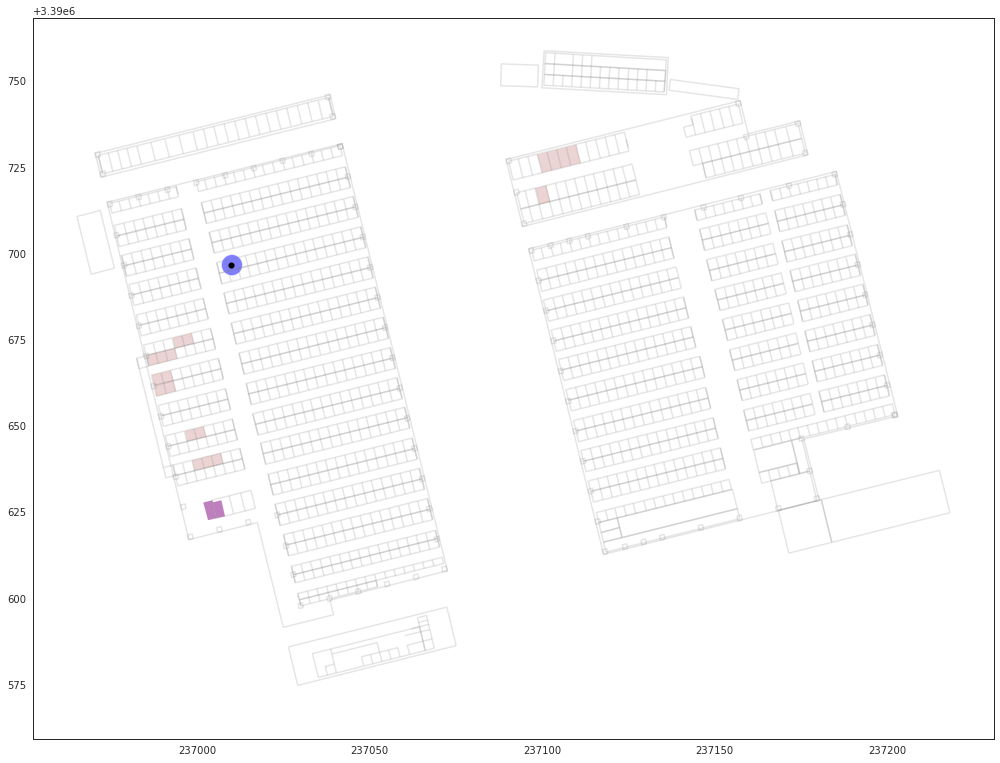

In [111]:
time_case_plot([df_cases_1_13], ['blue'], [0.5], [1], buffer=3, file_name='cases_13th_buffer_3m')

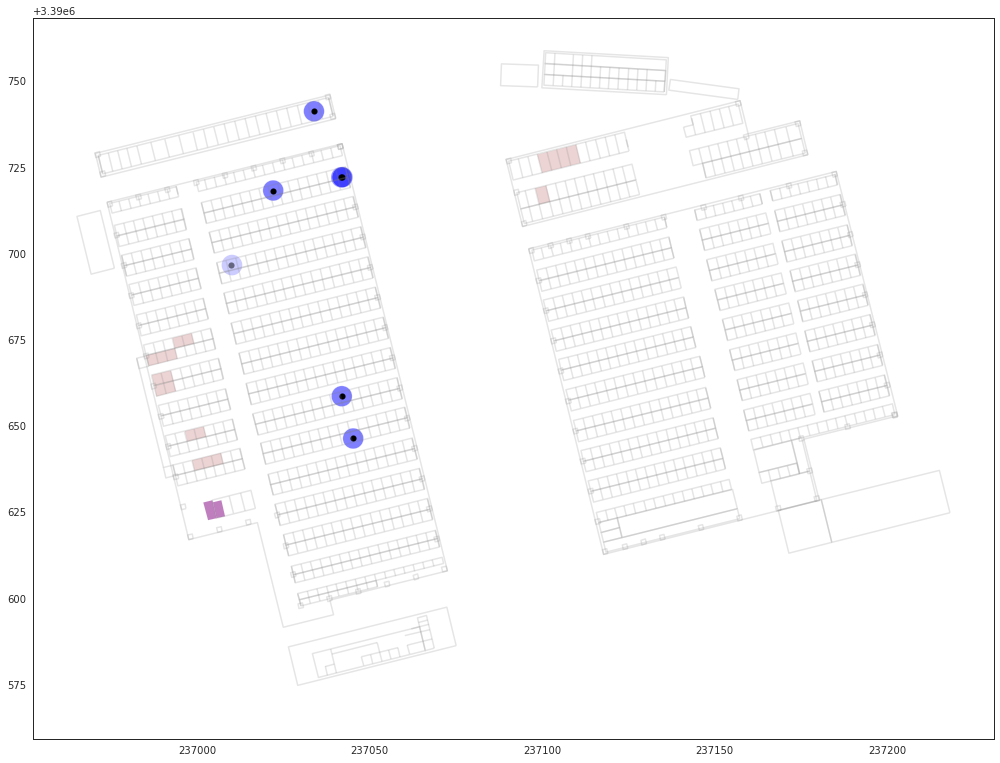

In [112]:
time_case_plot([df_cases_1_13, df_cases_20_new], ['blue', 'blue'], [0.2, 0.5], [0.5, 1], \
               buffer=3, file_name='cases_20th_buffer_3m')

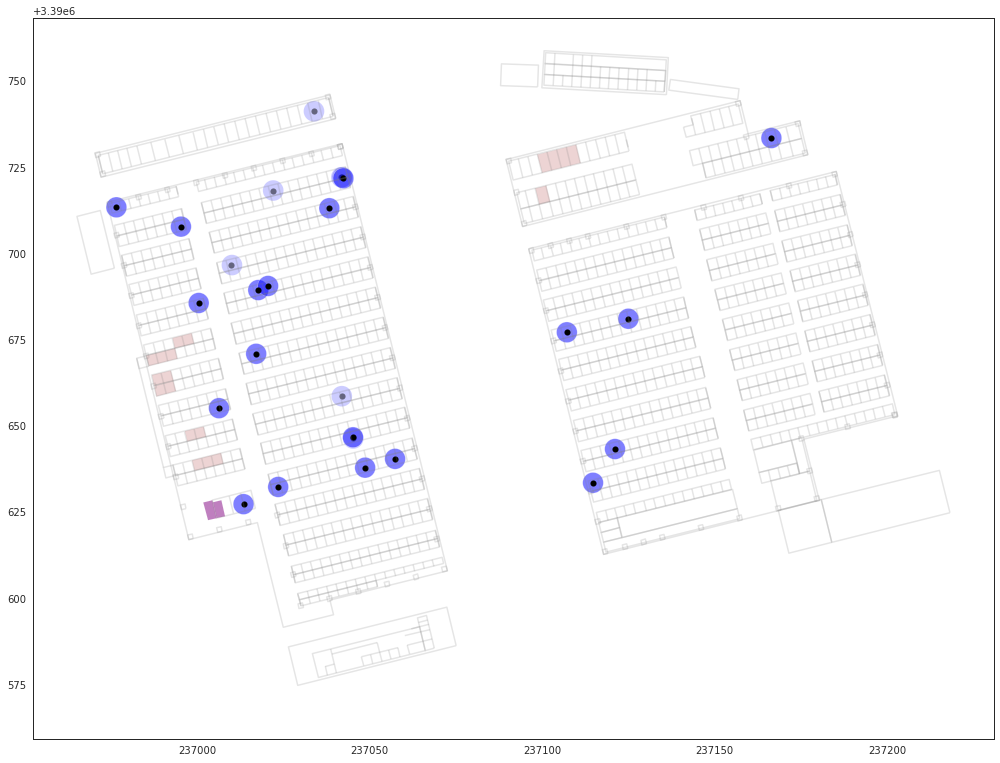

In [113]:
time_case_plot([df_cases_1_13, df_cases_20_new, df_cases_27_new], ['blue','blue', 'blue'],\
               [0.2, 0.2, 0.5], [0.5, 0.5, 1], buffer=3 , file_name='cases_27th_buffer_3m' )

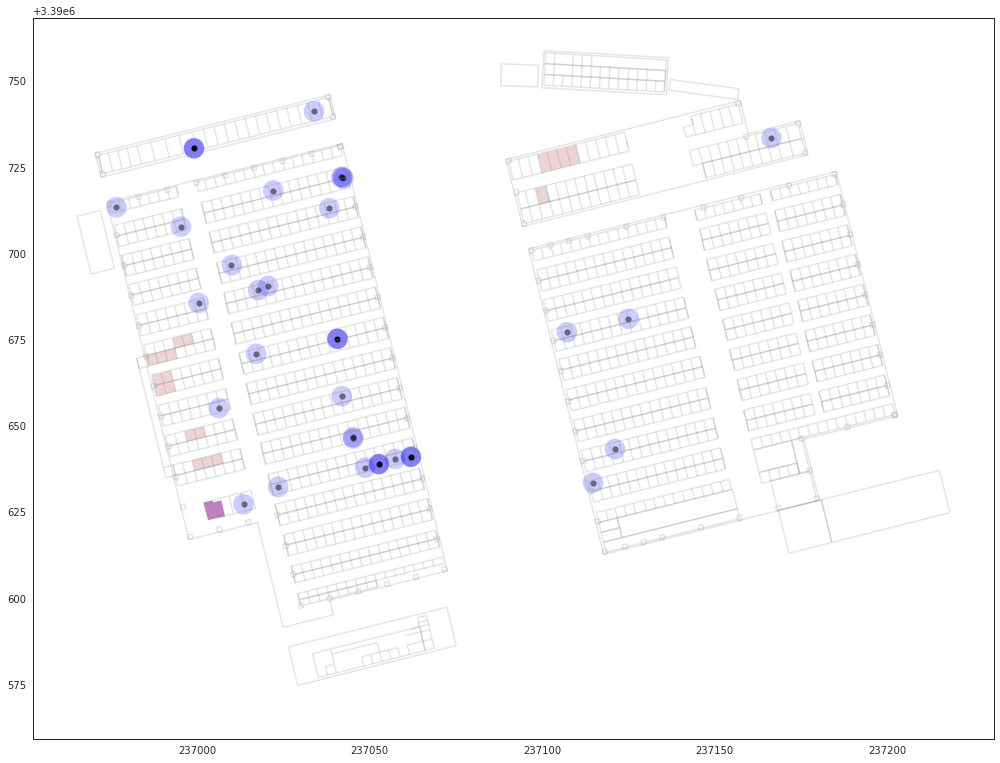

In [114]:
time_case_plot([df_cases_1_13, df_cases_20_new, df_cases_27_new, df_cases_31_new], ['blue','blue', 'blue', 'blue'],
               [0.2, 0.2, 0.2, 0.5], [0.5, 0.5, 0.5, 1], buffer=3 , file_name='cases_31st_buffer_3m')

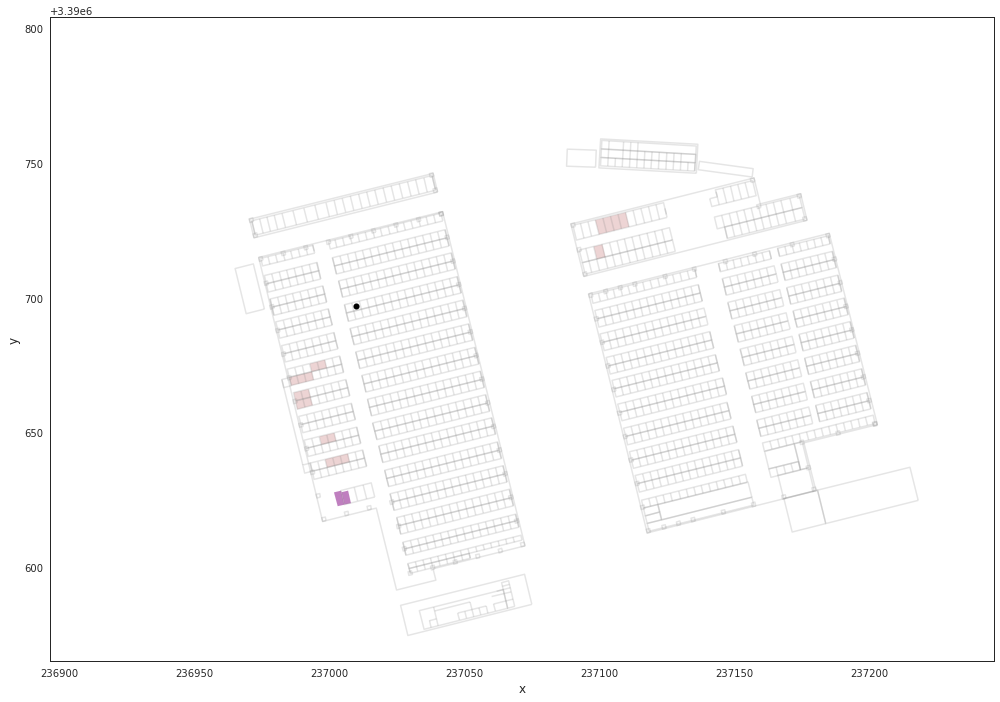

In [115]:
# Set up figure and axis
f, ax = plt.subplots(1, figsize=(14, 14))
# Generate and add KDE with a shading of 50 gradients
# coloured contours, 75% of transparency,
# viridis_r colormap

c=sns.kdeplot(
    df_cases_1_13["x"],
    df_cases_1_13["y"],
    n_levels=50,
    shade=True,
    alpha=0.4,
    cmap="viridis_r",
)

df_map.plot(ax=ax, color="grey", alpha = .2 )
df_cases_1_13.plot(ax=ax, color="black", linewidth=.1)
df_gao_wildlife.plot(ax=ax, color="brown", linewidth=.1, alpha=.2)
df_toilets.plot(ax=ax, color="purple", linewidth=.1, alpha=.5)

ax.set_xlim(236896.5302735323, 237246.22153647602)
ax.set_ylim(3390565.3631932065, 3390803.9439512226)

plt.tight_layout()
plt.savefig(DATA_PATH+f"Images/cases_13th_total_KDE_50.png") 

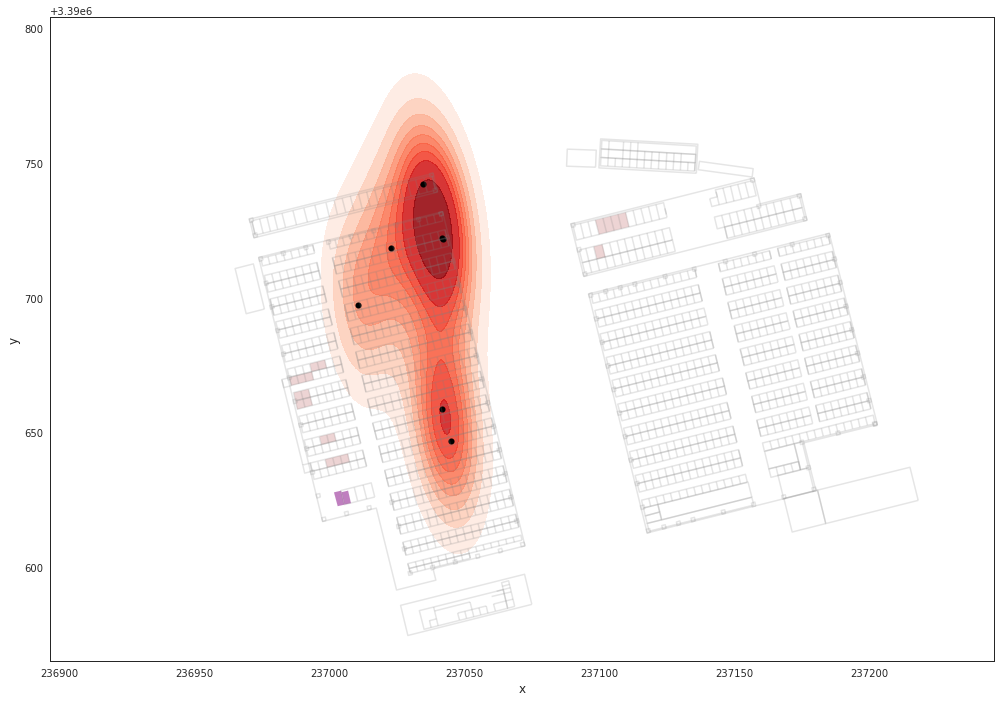

In [169]:
# Create thresholds
start = 0.1
n = 11
interval = 0.1
levels = np.arange(start, interval * n , interval)


# Create plot
f, ax = plt.subplots(ncols=1, figsize=(14, 14))
# Kernel Density Estimation
kde = sns.kdeplot(
    ax=ax,
    x=df_cases_20["x"],
    y=df_cases_20["y"],
    levels = levels,
    shade=True,
    cmap='Reds',
    alpha=0.9
)
# Add a basemap
#ctx.add_basemap(ax=ax,crs = env_sample_df.crs.to_string(), source=ctx.providers.CartoDB.Positron)
df_map.plot(ax=ax, color="grey", alpha = .2 )
df_cases_20.plot(ax=ax, color="black", linewidth=.1)
df_gao_wildlife.plot(ax=ax, color="brown", linewidth=.1, alpha=.2)
df_toilets.plot(ax=ax, color="purple", linewidth=.1, alpha=.5)
#ax.set_axis_off()
plt.tight_layout()
ax.set_xlim(236896.5302735323, 237246.22153647602)
ax.set_ylim(3390565.3631932065, 3390803.9439512226)


plt.savefig(DATA_PATH+f"Images/cases_20th_total_KDE_red_10.png") 

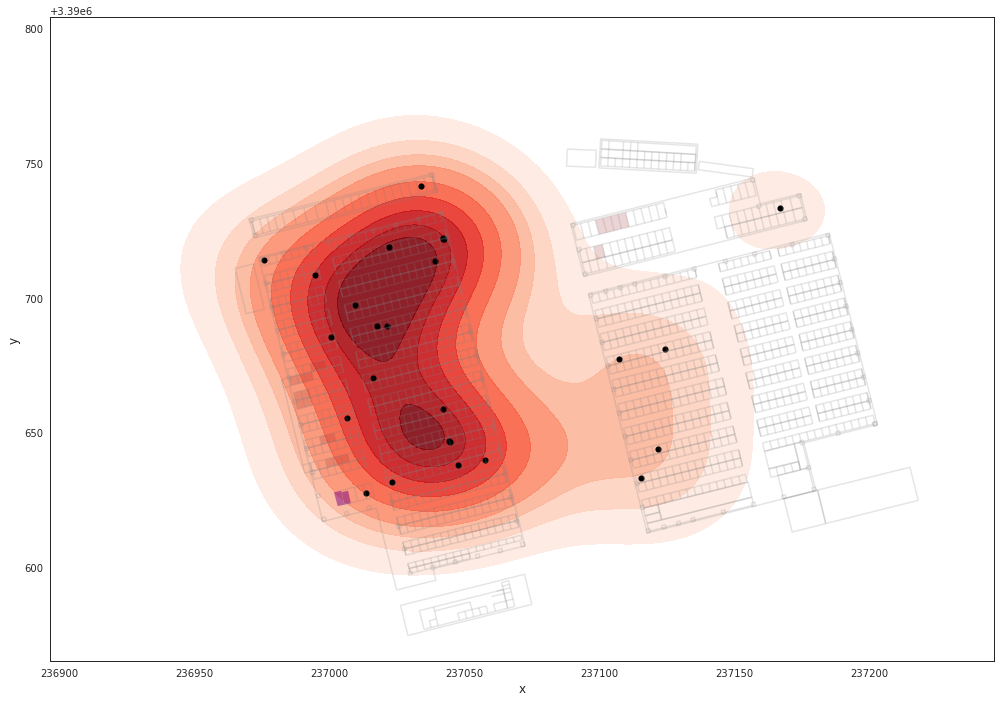

In [170]:
# Create thresholds
start = 0.1
n = 11
interval = 0.1
levels = np.arange(start, interval * n , interval)


# Create plot
f, ax = plt.subplots(ncols=1, figsize=(14, 14))
# Kernel Density Estimation
kde = sns.kdeplot(
    ax=ax,
    x=df_cases_27["x"],
    y=df_cases_27["y"],
    levels = levels,
    shade=True,
    cmap='Reds',
    alpha=0.9
)
# Add a basemap
#ctx.add_basemap(ax=ax,crs = env_sample_df.crs.to_string(), source=ctx.providers.CartoDB.Positron)
df_map.plot(ax=ax, color="grey", alpha = .2 )
df_cases_27.plot(ax=ax, color="black", linewidth=.1)
df_gao_wildlife.plot(ax=ax, color="brown", linewidth=.1, alpha=.2)
df_toilets.plot(ax=ax, color="purple", linewidth=.1, alpha=.5)
#ax.set_axis_off()
plt.tight_layout()
ax.set_xlim(236896.5302735323, 237246.22153647602)
ax.set_ylim(3390565.3631932065, 3390803.9439512226)

plt.savefig(DATA_PATH+f"Images/cases_27th_total_KDE_red_10.png") 

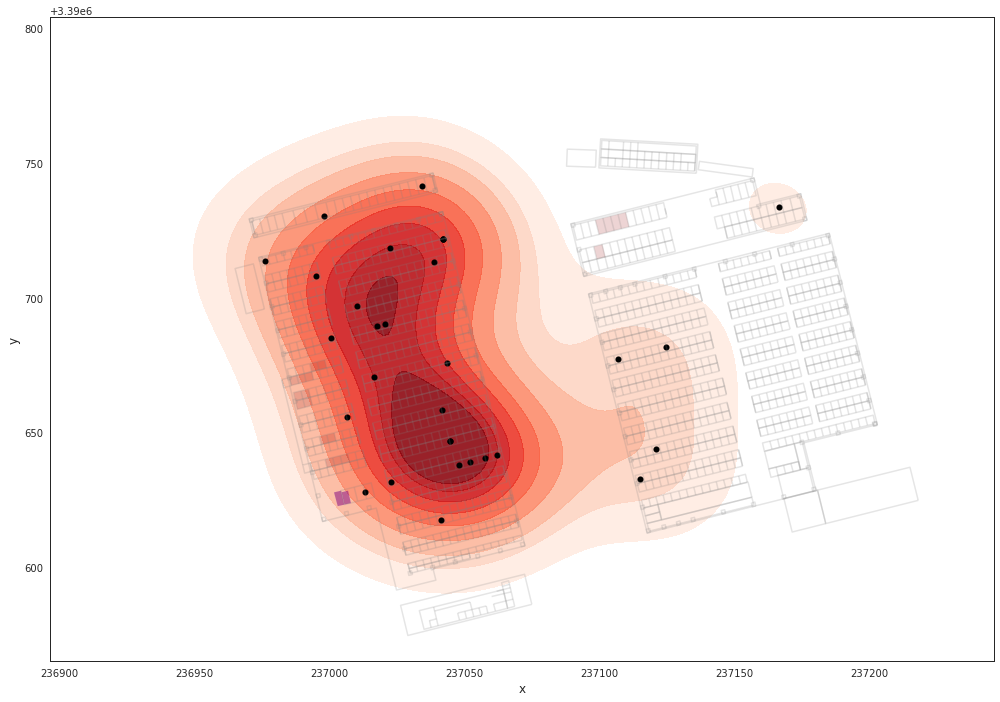

In [171]:
# Create thresholds
start = 0.1
n = 11
interval = 0.1
levels = np.arange(start, interval * n , interval)


# Create plot
f, ax = plt.subplots(ncols=1, figsize=(14, 14))
# Kernel Density Estimation
kde = sns.kdeplot(
    ax=ax,
    x=cases_df["x"],
    y= cases_df["y"],
    levels = levels,
    shade=True,
    cmap='Reds',
    alpha=0.9
)
# Add a basemap
#ctx.add_basemap(ax=ax,crs = env_sample_df.crs.to_string(), source=ctx.providers.CartoDB.Positron)
df_map.plot(ax=ax, color="grey", alpha = .2 )
cases_df.plot(ax=ax, color="black", linewidth=.1)
df_gao_wildlife.plot(ax=ax, color="brown", linewidth=.1, alpha=.2)
df_toilets.plot(ax=ax, color="purple", linewidth=.1, alpha=.5)
#ax.set_axis_off()
plt.tight_layout()
ax.set_xlim(236896.5302735323, 237246.22153647602)
ax.set_ylim(3390565.3631932065, 3390803.9439512226)

plt.savefig(DATA_PATH+f"Images/cases_31st_total_KDE_red_10.png") 

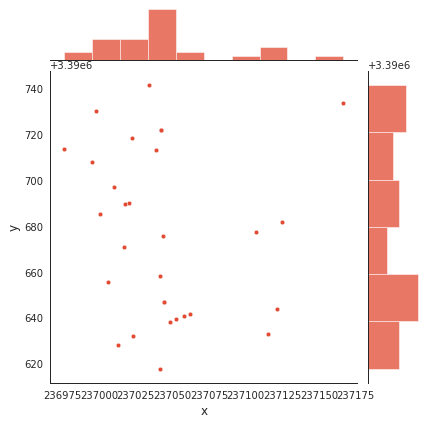

In [119]:
sns.jointplot(x="x", y="y", data=cases_df, s=20);

In [ ]:
# Experimental

In [172]:
df_w = gpd.read_file("/mnt/1TB_0/Data/GIS/Wuhan_Early_Cases/geojson/huanan-market-internal.geojson")

In [173]:
df_w_3857 = df_w.to_crs(epsg=3857)

In [177]:
df_map_3857 = df_map.to_crs(epsg=3857)

In [174]:
pos_sites=df_w_3857[df_w_3857["group"].isin(['Env-Pos'])].copy(deep=True)
neg_sites=df_w_3857[df_w_3857["group"].isin(['Env-Neg'])].copy(deep=True)

In [175]:
#same_stalls
#list('A14','A15','A90','A88','A87'),
#list('Q61','Q64','Q69','Q70','Q68')
#list('A2','A18','A20')
#list('F98','F100')
#list('Q93','A61'))

In [176]:
pos_sites.head(n=100)

,title,group,fill,label,marker-color,stroke,geometry
0,B17 (scale),Env-Pos,None,None,#cc1b15,None,POINT (12718938.887 3583513.696)
1,D32 (wagon surface),Env-Pos,None,None,#cc1b15,None,POINT (12718992.209 3583520.552)
2,F13 (wall surface),Env-Pos,None,None,#cc1b15,None,POINT (12718990.985 3583487.566)
3,"E48 (blood from ground surface, in front of door)",Env-Pos,None,None,#cc1b15,None,POINT (12719113.102 3583509.815)
4,E61 (ground surface),Env-Pos,None,None,#cc1b15,None,POINT (12719092.842 3583464.800)
5,Q37 (interior surface of freezer),Env-Pos,None,None,#cc1b15,None,POINT (12718976.179 3583450.829)
6,G93 (dirty water),Env-Pos,None,None,#cc1b15,None,POINT (12718989.537 3583454.580)
7,A61 (ground surface),Env-Pos,None,None,#cc1b15,None,POINT (12718990.428 3583450.958)
8,A63 (ground surface),Env-Pos,None,None,#cc1b15,None,POINT (12718998.554 3583453.157)
9,trash cart,Env-Pos,None,None,#cc1b15,None,POINT (12718955.362 3583437.764)


In [ ]:
#combo 1 Env-Pos <NA>  <NA>      #cc1b15   <NA> POINT (12718984 3583415)
#combo 2 Env-Pos <NA>  <NA>      #cc1b15   <NA> POINT (12718972 3583428)
#combo 3 Env-Pos <NA>  <NA>      #cc1b15   <NA> POINT (12719000 3583447)
#combo 4 Env-Pos <NA>  <NA>      #cc1b15   <NA> POINT (12719036 3583431)
#combo 5 Env-Pos <NA>  <NA>      #cc1b15   <NA> POINT (12718990 3583453)

In [180]:
#stall_center=list(c(114.25658,30.61937),c(114.256469, 30.61947),c(114.256724, 30.619613),\
#c(114.25704,30.61949),c(114.25663,30.61966))

env_ll = pd.DataFrame({'longitude': [114.25658, 114.256469, 114.256724, 114.25704, 114.25663],\
                   'latitude': [30.61937,  30.61947, 30.619613, 30.61949, 30.61966]})

g_env = gpd.points_from_xy(env_ll.longitude, env_ll.latitude, crs="EPSG:4326")

In [181]:
g_env_3857 = g_env.to_crs(epsg=3857)

In [189]:
gdf_centres = gpd.GeoDataFrame(env_ll, geometry=g_env_3857)

<AxesSubplot:>

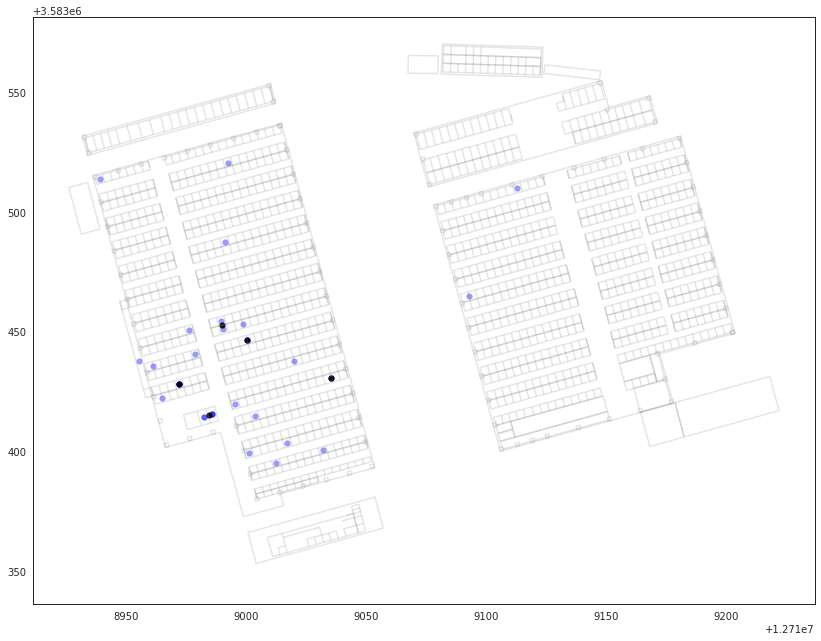

In [191]:
fig, ax = plt.subplots(figsize = (14,14))
df_map_3857.plot(ax=ax, color="grey", alpha = .2 )
pos_sites.plot(ax=ax, color="blue", linewidth=.1, alpha=0.4)
gdf_centres.plot(ax=ax, color="black", linewidth=.1, alpha=0.9)